Machinery for manufacturing LIBS type spectra

TODO: class docstrings AND Type Hints per:
https://realpython.com/documenting-python-code/
https://docs.python.org/3/library/typing.html

In [1]:
#imports and env
import numpy as np
import pickle
import math
from matplotlib import pyplot as plt
from scipy.special import voigt_profile as voigt
#needed to import our package from sibling directory
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
from libs_unet.training.spec_maker import spectrum_maker
from pathlib import Path

top_dir = Path.cwd().parent #working directory for notebook should be location of notebook
rel_path = 'data' 
datapath = top_dir / rel_path
datafile = "rel_int/top30_spec.pickle"

/Users/matt/CloudGit_local/github/gss/phaseMAP/envs/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<function matplotlib.pyplot.show(close=None, block=None)>

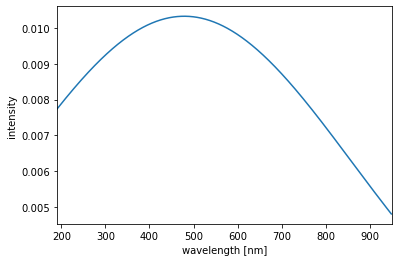

In [2]:
#explore Gaussian artifact formula
inc=1
w_lo=190 # lower limit of spectrum
w_hi=950 # upper limit of spectrum
maximum=0.1 #max relative intensity
sigma = (w_hi-w_lo) * 0.5
mu = np.random.randint(w_lo,w_hi)
wave = np.arange(w_lo,w_hi,inc)
bg = 100 * np.random.rand() * maximum * (1/(sigma * np.sqrt(2 * np.pi))) * np.exp( - (wave - mu)**2 / (2 * sigma**2))
plt.plot(wave, bg)
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950])
plt.show

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


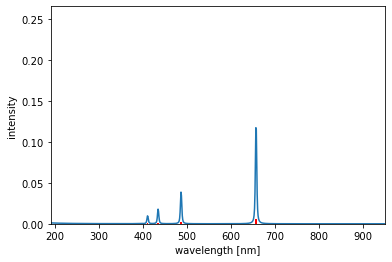

In [3]:
#Test peak maker method from class spectrum_maker
spec_maker = spectrum_maker(10)
wave, spec = spec_maker.peak_maker(element = "H", plot = True)
print(type(wave))
print(type(spec))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


<function matplotlib.pyplot.show(close=None, block=None)>

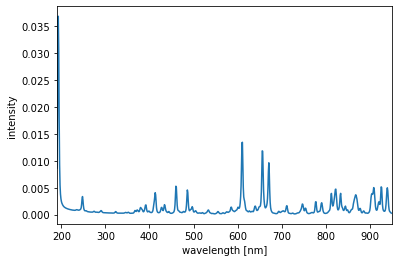

In [4]:
#Test method make_spectra from class spectrum_maker
spec_maker = spectrum_maker(10)
#first 10 elements
my_elem = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne']
my_fracs = [0.1, 0, 0.2, 0, 0, 0.3, 0.2, 0.1, 0, 0.1]
my_wave, my_spec, my_specarray = spec_maker.make_spectra(fracs=my_fracs)
print(type(my_wave), type(my_spec), type(my_specarray))

plt.plot(my_wave, my_spec)
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950])
plt.show

In [6]:
#test batch_spectra method
spec_maker = spectrum_maker(20)
fracs, wave, x_data, y_data = spec_maker.batch_spectra()
#confirm we recover the composite spectrum from the truncated aggregation of elements+art+noise
math.isclose(np.max(abs(np.where(np.sum(y_data[0], axis=0) < 0, 0, np.sum(y_data[0], axis=0)) - x_data[0])),0)

True

In [13]:
#generate and persist large data set for model training and validation
#Note: 10,000 samples with default settings (no mods, artifacts, noise) took 6m4s or ~27/sec
#Expect 1 million to require ~10 hours which is fine since not recurring task
#However, the 10k data set takes up 1.4Gb on disk when pickled, 250Mb when compressed
#May be smart to use cloud storage for this, AWS S3 or GCP and read the data in from there for training model variants
spec_maker = spectrum_maker(20)
fracs, wave, x_data, y_data = spec_maker.batch_spectra(batch=1000)

In [21]:
len(fracs)
type(wave[0])


numpy.int64

In [ ]:
#persist sample data and provide code to reload elsewhere
# better ways? https://stackoverflow.com/questions/20716812/saving-and-loading-multiple-objects-in-pickle-file
#1M records compressed might only be ~25Gb on disk, but probably break into many files to limit RAM footprint while processing
#with open(datapath / 'my_file', 'wb') as f:
#    pickle.dump(fracs, f)
#    pickle.dump(wave, f)
#    pickle.dump(x_data, f)
#    pickle.dump(y_data, f)

#To load in other modules
#with open(datapath / 'my_file', 'rb') as f:
#    fracs = pickle.load(f)
#    wave = pickle.load(f)
#    x_data = pickle.load(f)
#    y_data = pickle.load(f)

In [2]:
#create a dataset with fixed proportions on element pairs from first 20 elements
max_z = 20
spec_maker = spectrum_maker(max_z)
n_samples = 590 #20 pure + 20 choose 2 with 3 mix ratios for each unique pair
fracs = np.zeros((n_samples,max_z))
frac_count = 0
#add pure element instances
for i in range(max_z):
    fracs[frac_count,i] = 1
    frac_count += 1
#now add combinations
for i in range(max_z - 1): #Very last element has nothing ahead to pair with
    for j in range(i+1,max_z): #new pairs start at next element and goto last
        fracs[frac_count,i] = 0.9
        fracs[frac_count,j] = 0.1
        frac_count += 1
        fracs[frac_count,i] = 0.5
        fracs[frac_count,j] = 0.5
        frac_count += 1
        fracs[frac_count,i] = 0.1
        fracs[frac_count,j] = 0.9
        frac_count += 1


In [3]:
print(len(fracs))
print(np.sum(fracs,0))

590
[29.5 29.5 29.5 29.5 29.5 29.5 29.5 29.5 29.5 29.5 29.5 29.5 29.5 29.5
 29.5 29.5 29.5 29.5 29.5 29.5]


In [8]:
#construct 590 sample data set to persist
wave = np.arange(190,950,1) #only needed for correct length
x_data = np.zeros((n_samples, len(wave)))
y_data = np.zeros((n_samples, int(max_z+2), len(wave)))

#note the wave range generated from w_lo, w_hi, inc is going to be same in each sample
# make_spectra also returns composite spectra and array of weighted element spectra, artifacts, noise
for i in np.arange(n_samples):
    wave, x_data[i], y_data[i] = spec_maker.make_spectra(fracs=fracs[i], inc=1, w_lo=190, w_hi=950)

Mg:0.5
K:0.5


<function matplotlib.pyplot.show(close=None, block=None)>

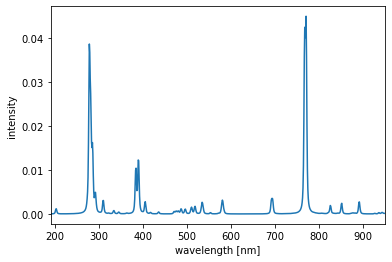

In [11]:
#Inspect combinations / compositions
#Build array of first 94 element labels and abundance from text files (wikipedia)
elem_symb = np.loadtxt(datapath / "abundance/elements_94.csv", dtype=str)

sample_num = 501 # <590
test_frac = fracs[sample_num]

for i in range(max_z):
    if test_frac[i] > 0:
        print(f"{elem_symb[i]}:{test_frac[i]}")

plt.plot(wave, x_data[sample_num]) 
plt.xlabel('wavelength [nm]')   
plt.ylabel('intensity')
plt.xlim([190, 950]) #note data may go beyond this range
plt.show

In [12]:
#persist sample data and provide code to reload elsewhere
with open(datapath / 'training' / 'z20_pairs.pickle', 'wb') as f:
    pickle.dump(fracs, f)
    pickle.dump(wave, f)
    pickle.dump(x_data, f)
    pickle.dump(y_data, f)

#To load in other modules
#with open(datapath / 'training' / 'z20_pairs.pickle', 'rb') as f:
#    fracs = pickle.load(f)
#    wave = pickle.load(f)
#    x_data = pickle.load(f)
#    y_data = pickle.load(f)